# Irony Detection in English Tweets

* João Dossena - UP201800174
* João Rosário - UP201806334
* João Sousa - UP201806613

MIEIC, Class 8, Group 14

## Project Specification

The project is made up of two subtasks.
In the first one the objective is the detection of irony given a tweet in English, marking it out either with a value of 0 or 1 if irony is absent or not, respectively.
In the second subtask the goal is to classify the type of irony into 4 classes:
1. verbal irony realized through a polarity contrast
2. verbal irony without such a polarity contrast (i.e., other verbal irony)
3. descriptions of situational irony
4. non-irony

The datasets provided consisted of a set of entries where the first column was the tweet index, the second one was the label (either 0 or 1, or 0, 1, 2 or 3 depending on the task) in the case of the training data or the tweet text which corresponds to the third column in the training datasets.

## Required Libraries

* pandas
* sklearn
* re
* nltk
* imblearn
* time
* seaborn
* matplotlib
* numpy

# Task A

## Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
%matplotlib inline 
sns.set(color_codes=True)

In [2]:
# Get data from file
def readData(path_train, path_test):
    df = pd.read_csv(path_train, sep="\t")
    test_df = pd.read_csv(path_test, sep="\t")
    print("Data Read Successfully")
    return (df, test_df)

In [3]:
(train_df, test_df) = readData("../datasets/train/train-taskA.txt", "../datasets/test/gold_test_taskA.txt")

Data Read Successfully


In [4]:
train_df.shape

(3817, 3)

In [5]:
test_df.shape

(784, 3)

In [6]:
# checking if data was actually read correctly
train_df.head()

,Tweet index,Label,Tweet text
0,1,1,Sweet United Nations video. Just in time for C...
1,2,1,@mrdahl87 We are rumored to have talked to Erv...
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...
3,4,0,3 episodes left I'm dying over here
4,5,1,I can't breathe! was chosen as the most notabl...


In [7]:
# checking if there are any null values present in the dataset
train_df.isnull().sum()

Tweet index    0
Label          0
Tweet text     0
dtype: int64

Label
0    1916
1    1901
Name: Tweet text, dtype: int64


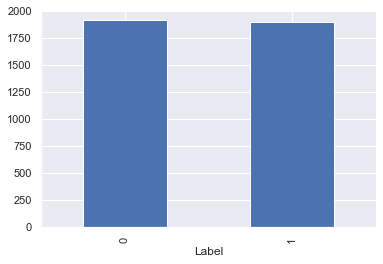

In [8]:
print(train_df.groupby('Label')['Tweet text'].count())
train_df.groupby('Label')['Tweet text'].count().plot.bar(ylim=0)
plt.show()

The data appears to be balanced. There isn't a significant difference between the number of entries per label. Therefore over/undersampling doesn't seem to be needed.

## Text processing

In [9]:
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score


def processing(Corpus):
    # Step - a : Remove blank rows if any.
    Corpus['Tweet text'].dropna(inplace=True)
    
    # Step - b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
    Corpus['Tweet text'] = [entry.lower() for entry in Corpus['Tweet text']]
    
    # Step - c : @Usernames and links removed / Tokenization : each entry in the corpus will be broken into set of words
    Corpus['Tweet text'] = [re.sub('@[a-zA-Z0-9_]+|https?://t.co/[a-zA-Z0-9_]+|[^a-zA-Z]', ' ', entry) for entry in Corpus['Tweet text']]
    Corpus['Tweet text']= [word_tokenize(entry) for entry in Corpus['Tweet text']]
    
    # Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
    # WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV
    for index,entry in enumerate(Corpus['Tweet text']):
        
        # Declaring Empty List to store the words that follow the rules for this step
        Final_words = []
        
        # Initializing WordNetLemmatizer()
        word_Lemmatized = WordNetLemmatizer()
        
        # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
        for word, tag in pos_tag(entry):
            # Below condition is to check for Stop words and consider only alphabets
            if word not in stopwords.words('english') and word.isalpha():
                word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
                Final_words.append(word_Final)
        # The final processed set of words for each iteration will be stored in 'text_final'
        Corpus.loc[index,'text_final'] = str(Final_words)
    
    print("Processed df")
    return Corpus

def processing_2(df):
    stemmer = LancasterStemmer()
    corpus = []
    for i in range(len(df)):
        
        # get tweet and remove usernames (@username) and links to pictures (https://t.co/link)
        tweet = re.sub('@[a-zA-Z0-9_]+|https?://t.co/[a-zA-Z0-9_]+|[^a-zA-Z]', ' ', df['Tweet text'][i])

        # to lower-case and tokenize
        tweet = tweet.lower().split()

        # Stemming and stop word removal
        stemmed_tweet = ' '.join([stemmer.stem(w) for w in tweet if not w in set(stopwords.words('english'))])
        corpus.append(stemmed_tweet)
    
    print("Processed df")
    return corpus

In [10]:
# train and test processing
corpus_2 = processing_2(train_df)
test_corpus_2 = processing_2(test_df)

corpus = processing(train_df)
test_corpus = processing(test_df)

Processed df
Processed df
Processed df
Processed df


In [11]:
from sklearn.feature_extraction.text import CountVectorizer

# Create bag-of-words model
def bagOfWords(df, corpus):
    vectorizer = CountVectorizer(max_features = 1500) # original = 1500
    X = vectorizer.fit_transform(corpus).toarray()
    y = df.iloc[:,1].values

    return (X, y)

In [12]:
# Function that displays the confusion matrix
def plot_conf_matrix(Test_Y, y_pred):
    conf_matrix = confusion_matrix(y_true=Test_Y, y_pred=y_pred)
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

In [13]:
Train_X = corpus['text_final']
Train_Y = corpus.iloc[:,1].values

Test_X = test_corpus['text_final']
Test_Y = test_corpus.iloc[:,1].values


(Train_X_2, Train_Y_2) = bagOfWords(train_df, corpus_2)
(Test_X_2, Test_Y_2) = bagOfWords(test_df, test_corpus_2)

In [14]:
# Word Vectorization
print("TfidfVectorizer max_features=5000")
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(corpus['text_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

TfidfVectorizer max_features=5000


## Algorithms and Parameter Tuning

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

import time

### Support Vector Machines

In [16]:
from sklearn.svm import SVC

In [17]:
# SVM default
def svm_default(X_train, X_test, y_train, y_test):
    
    print("SVM (default parameters)")
    classifier = SVC()
    return svm(classifier, X_train, X_test, y_train, y_test)

# SVM optimized (using parameter found by findSVC - function ahead)
def svm_optimized(X_train, X_test, y_train, y_test):
    
    print("SVM ('C': 1, 'kernel': 'sigmoid')")
    classifier = SVC(C=1, kernel='sigmoid')
    return svm(classifier, X_train, X_test, y_train, y_test)
    

# SVM
def svm(classifier, X_train, X_test, y_train, y_test):
    
    time_0 = time.time()
    classifier.fit(X_train, y_train)
    training_time = str(round(time.time()-time_0,3))
    
    time_1 = time.time()
    y_pred = classifier.predict(X_test)
    predict_time = str(round(time.time()-time_1,3))
    
    print("Training Time (seconds): " + training_time)
    print("Predict Time (seconds): " + predict_time)
    
    print(classification_report(y_test, y_pred))
    
    plot_conf_matrix(Test_Y, y_pred)
    
    return (classification_report(y_test, y_pred, output_dict=True), training_time, predict_time, y_test, y_pred)

SVM ('C': 1, 'kernel': 'sigmoid')
Training Time (seconds): 0.734
Predict Time (seconds): 0.108
              precision    recall  f1-score   support

           0       0.72      0.64      0.67       473
           1       0.53      0.61      0.57       311

    accuracy                           0.63       784
   macro avg       0.62      0.63      0.62       784
weighted avg       0.64      0.63      0.63       784



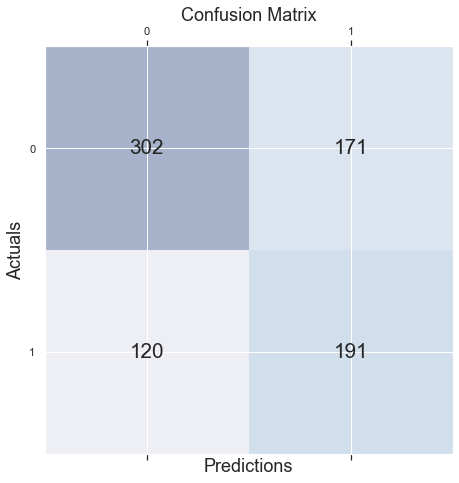


-----

SVM (default parameters)
Training Time (seconds): 0.837
Predict Time (seconds): 0.148
              precision    recall  f1-score   support

           0       0.71      0.68      0.70       473
           1       0.55      0.58      0.56       311

    accuracy                           0.64       784
   macro avg       0.63      0.63      0.63       784
weighted avg       0.65      0.64      0.64       784



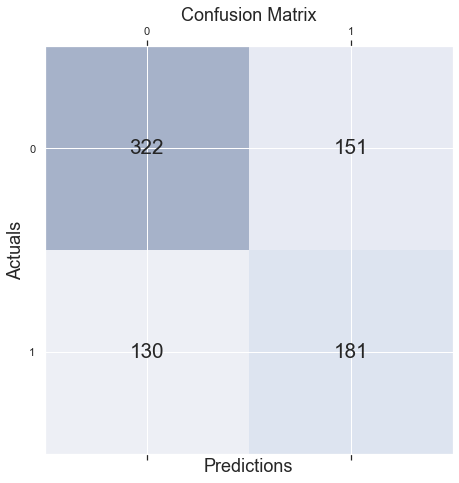

In [18]:
# Using Lemmatization / Word Vectorization
(svc_optimized, svc_optimized_train_time, svc_optimized_predict_time, svc_optimized_y_test, svc_optimized_y_pred) = svm_optimized(Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y)
print("\n-----\n")
(svc_for_graph, svc_train_time, svc_predict_time, svc_y_test, svc_y_pred) = svm_default(Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y)

SVM ('C': 1, 'kernel': 'sigmoid')
Training Time (seconds): 8.429
Predict Time (seconds): 1.527
              precision    recall  f1-score   support

           0       0.58      0.65      0.61       473
           1       0.35      0.29      0.32       311

    accuracy                           0.51       784
   macro avg       0.47      0.47      0.47       784
weighted avg       0.49      0.51      0.50       784



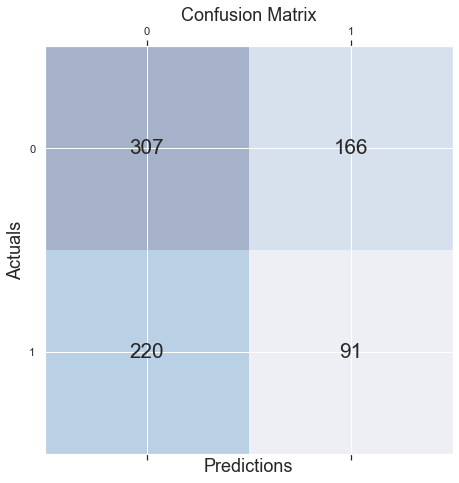


-----

SVM (default parameters)
Training Time (seconds): 9.718
Predict Time (seconds): 2.729
              precision    recall  f1-score   support

           0       0.59      0.77      0.66       473
           1       0.34      0.18      0.23       311

    accuracy                           0.53       784
   macro avg       0.46      0.47      0.45       784
weighted avg       0.49      0.53      0.49       784



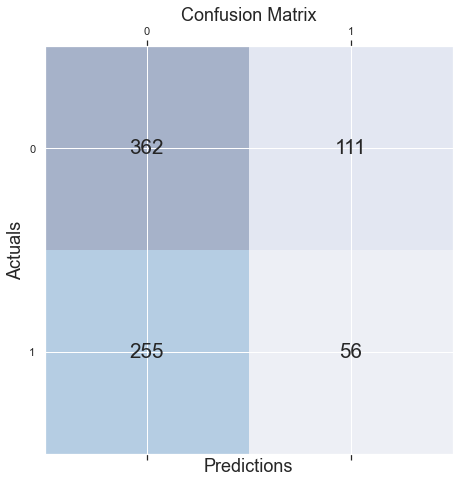

In [19]:
# Using Stemming / Bag-of-words
(svc_optimized, svc_optimized_train_time, svc_optimized_predict_time, svc_optimized_y_test, svc_optimized_y_pred) = svm_optimized(Train_X_2, Test_X_2, Train_Y_2, Test_Y_2)
print("\n-----\n")
(svc_for_graph, svc_train_time, svc_predict_time, svc_y_test, svc_y_pred) = svm_default(Train_X_2, Test_X_2, Train_Y_2, Test_Y_2)

In [20]:
# Using GridSearch to try to find the best parameters
def findSVC(X_train, X_test, y_train, y_test):

    tuned_parameters = {'kernel': ['linear', 'poly', 'sigmoid'],
                        'C': [0.5, 1.0, 2.0]
                    }

    clf = GridSearchCV(SVC(), tuned_parameters, n_jobs=-1, cv=3)
    clf.fit(X_train, y_train)

    print('Best parameters found:\n', clf.best_params_)

    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

    y_true, y_pred = y_test , clf.predict(X_test)

    print('Results on the test set:')
    print(classification_report(y_true, y_pred))
    
    return classification_report(y_test, y_pred, output_dict=True)

In [21]:
svc_tunning_for_graph = findSVC(Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y)

Best parameters found:
 {'C': 1.0, 'kernel': 'sigmoid'}
0.612 (+/-0.029) for {'C': 0.5, 'kernel': 'linear'}
0.511 (+/-0.008) for {'C': 0.5, 'kernel': 'poly'}
0.611 (+/-0.026) for {'C': 0.5, 'kernel': 'sigmoid'}
0.610 (+/-0.042) for {'C': 1.0, 'kernel': 'linear'}
0.596 (+/-0.024) for {'C': 1.0, 'kernel': 'poly'}
0.613 (+/-0.037) for {'C': 1.0, 'kernel': 'sigmoid'}
0.602 (+/-0.036) for {'C': 2.0, 'kernel': 'linear'}
0.595 (+/-0.014) for {'C': 2.0, 'kernel': 'poly'}
0.597 (+/-0.036) for {'C': 2.0, 'kernel': 'sigmoid'}
Results on the test set:
              precision    recall  f1-score   support

           0       0.72      0.64      0.67       473
           1       0.53      0.61      0.57       311

    accuracy                           0.63       784
   macro avg       0.62      0.63      0.62       784
weighted avg       0.64      0.63      0.63       784



### Linear Model - Perceptron

In [22]:
from sklearn.linear_model import Perceptron

# Perceptron
def perceptron(X_train, X_test, y_train, y_test):
    classifier = Perceptron()
    
    time_0 = time.time()
    classifier.fit(X_train, y_train)
    training_time = str(round(time.time()-time_0,5))
    
    time_1 = time.time()
    y_pred = classifier.predict(X_test)
    
    predict_time = str(round(time.time()-time_1,5))
    
    print("Training Time (seconds): " + training_time)
    print("Predict Time (seconds): " + predict_time)

    print(classification_report(y_test, y_pred))
    
    plot_conf_matrix(Test_Y, y_pred)
    
    return (classification_report(y_test, y_pred, output_dict=True), training_time, predict_time, y_test, y_pred)

Training Time (seconds): 0.01
Predict Time (seconds): 0.0
              precision    recall  f1-score   support

           0       0.69      0.62      0.65       473
           1       0.50      0.59      0.54       311

    accuracy                           0.60       784
   macro avg       0.60      0.60      0.60       784
weighted avg       0.62      0.60      0.61       784



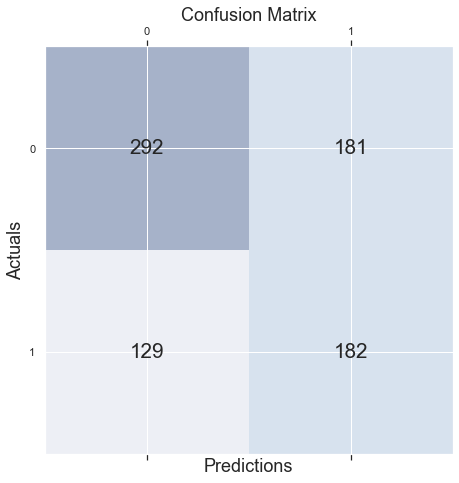

In [23]:
(perceptron_default_for_graph, perceptron_train_time, perceptron_predict_time, perceptron_y_test, perceptron_y_pred) = perceptron(Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y)

In [24]:
def findPerceptron(X_train, X_test, y_train, y_test):
    
    parameter_space = {
        'penalty': ['l2', 'l1', 'elasticnet'],
        'alpha': [0.05, 0.0001],
        'max_iter': [100, 200, 500, 1000, 2000],
    }

    clf = GridSearchCV(Perceptron(), parameter_space, n_jobs=-1, cv=3)
    clf.fit(X_train, y_train)

    # Best paramete set
    print('Best parameters found:\n', clf.best_params_)

    # All results
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

    y_true, y_pred = y_test , clf.predict(X_test)

    print('Results on the test set:')
    print(classification_report(y_true, y_pred))
    
    return classification_report(y_test, y_pred, output_dict=True)

In [25]:
perceptron_tunning_for_graph = findPerceptron(Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y)

Best parameters found:
 {'alpha': 0.0001, 'max_iter': 100, 'penalty': 'elasticnet'}
0.495 (+/-0.019) for {'alpha': 0.05, 'max_iter': 100, 'penalty': 'l2'}
0.500 (+/-0.004) for {'alpha': 0.05, 'max_iter': 100, 'penalty': 'l1'}
0.500 (+/-0.004) for {'alpha': 0.05, 'max_iter': 100, 'penalty': 'elasticnet'}
0.495 (+/-0.019) for {'alpha': 0.05, 'max_iter': 200, 'penalty': 'l2'}
0.500 (+/-0.004) for {'alpha': 0.05, 'max_iter': 200, 'penalty': 'l1'}
0.500 (+/-0.004) for {'alpha': 0.05, 'max_iter': 200, 'penalty': 'elasticnet'}
0.495 (+/-0.019) for {'alpha': 0.05, 'max_iter': 500, 'penalty': 'l2'}
0.500 (+/-0.004) for {'alpha': 0.05, 'max_iter': 500, 'penalty': 'l1'}
0.500 (+/-0.004) for {'alpha': 0.05, 'max_iter': 500, 'penalty': 'elasticnet'}
0.495 (+/-0.019) for {'alpha': 0.05, 'max_iter': 1000, 'penalty': 'l2'}
0.500 (+/-0.004) for {'alpha': 0.05, 'max_iter': 1000, 'penalty': 'l1'}
0.500 (+/-0.004) for {'alpha': 0.05, 'max_iter': 1000, 'penalty': 'elasticnet'}
0.495 (+/-0.019) for {'alpha'

### Neural Networks

In [26]:
from sklearn.neural_network import MLPClassifier

In [27]:
# Multi Layered Perceptron
def mlp(X_train, X_test, y_train, y_test):
    
    classifier = MLPClassifier()
    time_0 = time.time()
    classifier.fit(X_train, y_train)
    training_time = str(round(time.time()-time_0,5))
    
    time_1 = time.time()
    y_pred = classifier.predict(X_test)
    predict_time = str(round(time.time()-time_1,5))
    
    print("Training Time (seconds): " + training_time)
    print("Predict Time (seconds): " + predict_time)
    
    print(classification_report(y_test, y_pred))
    
    plot_conf_matrix(Test_Y, y_pred)
    
    return (classification_report(y_test, y_pred, output_dict=True), training_time, predict_time, y_test, y_pred)

Training Time (seconds): 64.54635
Predict Time (seconds): 0.001
              precision    recall  f1-score   support

           0       0.72      0.61      0.66       473
           1       0.52      0.64      0.57       311

    accuracy                           0.62       784
   macro avg       0.62      0.62      0.62       784
weighted avg       0.64      0.62      0.62       784



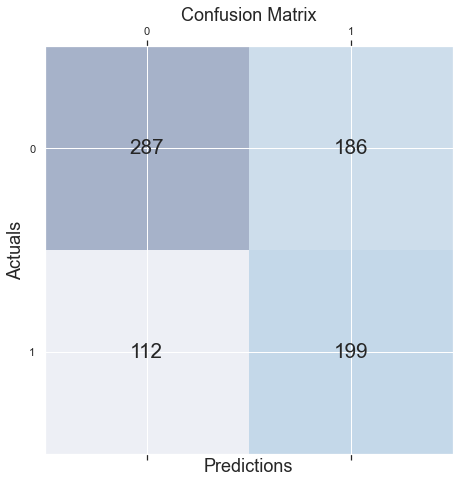

In [28]:
(mlp_default_for_graph, mlp_train_time, mlp_predict_time, mlp_y_test, mlp_y_pred) = mlp(Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y)

In [29]:
# Finding the best parameters for MLP
def findMlp(X_train, X_test, y_train, y_test):
    
    parameter_space = {
        'hidden_layer_sizes': [(20,20), (50,50), (50,50,50), (10,10), (100)],
        'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'solver': ['sgd'],
        'alpha': [0.05, 0.0001],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
        'max_iter': [100, 200, 500],
    }

    clf = GridSearchCV(MLPClassifier(), parameter_space, n_jobs=-1, cv=3)
    clf.fit(X_train, y_train)

    # Best paramete set
    print('Best parameters found:\n', clf.best_params_)

    # All results
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

    y_true, y_pred = y_test , clf.predict(X_test)

    print('Results on the test set:')
    print(classification_report(y_true, y_pred))
    
    return classification_report(y_test, y_pred, output_dict=True)

In [ ]:
mlp_tunning_for_graph = findMlp(Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y)

### Comparisons between Algorithms

In [ ]:
import matplotlib.patches as mpatches

In [ ]:
data = [
            [svc_for_graph['accuracy'], perceptron_default_for_graph['accuracy'], mlp_default_for_graph['accuracy']],
            [svc_tunning_for_graph['accuracy'], perceptron_tunning_for_graph['accuracy'], mlp_tunning_for_graph['accuracy']]
       ]

X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
ax.bar(X + 0.0, data[0], color = '#3275a8', width = 0.25, tick_label=['SVM', 'Perceptron', 'MLP'])
ax.bar(X + 0.25, data[1], color = '#258f3c', width = 0.25)

plt.xticks([0.125,1.125,2.125], ['SVM', 'Perceptron', 'MLP'])

default_patch = mpatches.Patch(color='#3275a8', label='Default Algorithm')
tunned_patch = mpatches.Patch(color='#258f3c', label='GridSearch Tuned')
plt.legend(handles=[default_patch, tunned_patch], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.xlabel("Algorithm")
plt.ylabel("Accuracy")
plt.title("Accuracy obtained by each algorithm")

print()

In [ ]:
data = [
            [float(svc_train_time), float(perceptron_train_time), float(mlp_train_time)]
       ]

X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
ax.bar(X, data[0], color = '#3275a8', width = 0.25, tick_label=['SVM', 'Perceptron', 'MLP'])

default_patch = mpatches.Patch(color='#3275a8', label='Time')
plt.legend(handles=[default_patch], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.xlabel("Algorithm")
plt.ylabel("Training Time (s)")
plt.title("Training Time for each algorithm")

print()

In [ ]:
data = [
            [float(svc_predict_time), float(perceptron_predict_time), float(mlp_predict_time)]
       ]

X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
ax.bar(X, data[0], color = '#3275a8', width = 0.25, tick_label=['SVM', 'Perceptron', 'MLP'])

default_patch = mpatches.Patch(color='#3275a8', label='Time')
plt.legend(handles=[default_patch], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.xlabel("Algorithm")
plt.ylabel("Prediction Time (s)")
plt.title("Prediction Time for each algorithm")

print()

In [ ]:
data = [
            [accuracy_score(svc_y_test, svc_y_pred), accuracy_score(perceptron_y_test, perceptron_y_pred), accuracy_score(mlp_y_test, mlp_y_pred)],
            [precision_score(svc_y_test, svc_y_pred), precision_score(perceptron_y_test, perceptron_y_pred), precision_score(mlp_y_test, mlp_y_pred)],
            [recall_score(svc_y_test, svc_y_pred), recall_score(perceptron_y_test, perceptron_y_pred), recall_score(mlp_y_test, mlp_y_pred)],
            [f1_score(svc_y_test, svc_y_pred), f1_score(perceptron_y_test, perceptron_y_pred), f1_score(mlp_y_test, mlp_y_pred)]
       ]

X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
ax.bar(X + 0.0, data[0], color = '#3275a8', width = 0.2)
ax.bar(X + 0.2, data[1], color = '#258f3c', width = 0.2)
ax.bar(X + 0.40, data[2], color = '#d1682c', width = 0.2)
ax.bar(X + 0.6, data[3], color = '#9fd12c', width = 0.2)

plt.xticks([0.25,1.25,2.25], ['SVM', 'Perceptron', 'MLP'])

default_patch = mpatches.Patch(color='#3275a8', label='Accuracy')
tunned_patch = mpatches.Patch(color='#258f3c', label='Precision')
tunned_patch_2 = mpatches.Patch(color='#d1682c', label='Recall')
tunned_patch_3 = mpatches.Patch(color='#9fd12c', label='F1')
plt.legend(handles=[default_patch, tunned_patch, tunned_patch_2, tunned_patch_3], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.xlabel("Algorithm")
plt.ylabel("Score")
plt.title("Scores obtained by each algorithm")

print()

# Task B

## Exploratory Data Analysis

In [ ]:
(train_df, test_df) = readData("../datasets/train/train-taskB.txt", "../datasets/test/gold_test_taskB.txt")

In [ ]:
train_df.shape

In [ ]:
test_df.shape

In [ ]:
train_df.head()

In [ ]:
# checking if there are any null values present in the dataset
train_df.isnull().sum()

In [ ]:
train_df.groupby('Label')['Tweet text'].count()
train_df.groupby('Label')['Tweet text'].count().plot.bar(ylim=0)
plt.show()

There isn't an uniform number of entries across all possible labels. The dataset is unbalanced. Therefore, we will try under/oversampling.

## Text Processing

In [ ]:
def processing(Corpus):
    # Step - a : Remove blank rows if any.
    Corpus['Tweet text'].dropna(inplace=True)
    
    # Step - b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
    Corpus['Tweet text'] = [entry.lower() for entry in Corpus['Tweet text']]
    
    # Step - c : Remove usernames / links / Tokenization : In this each entry in the corpus will be broken into set of words
    Corpus['Tweet text'] = [re.sub('@[a-zA-Z0-9_]+|https?://t.co/[a-zA-Z0-9_]+|[^a-zA-Z]', ' ', entry) for entry in Corpus['Tweet text']]
    Corpus['Tweet text']= [word_tokenize(entry) for entry in Corpus['Tweet text']]
    
    # Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV
    for index,entry in enumerate(Corpus['Tweet text']):
        
        # Declaring Empty List to store the words that follow the rules for this step
        Final_words = []
        
        # Initializing WordNetLemmatizer()
        word_Lemmatized = WordNetLemmatizer()
        
        # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
        for word, tag in pos_tag(entry):
            # Below condition is to check for Stop words and consider only alphabets
            if word not in stopwords.words('english') and word.isalpha():
                word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
                Final_words.append(word_Final)
        # The final processed set of words for each iteration will be stored in 'text_final'
        Corpus.loc[index,'text_final'] = str(Final_words)
    
    print("Processed")
    return Corpus

In [ ]:
corpus = processing(train_df)
test_corpus = processing(test_df)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot

In [ ]:
def smote(X_train, y_train):

    sm = SMOTE()
    X_train, y_train = sm.fit_resample(X_train, y_train)

    return (X_train, y_train)

In [ ]:
Train_X = corpus['text_final']
Train_Y = corpus.iloc[:,1].values

Test_X = test_corpus['text_final']
Test_Y = test_corpus.iloc[:,1].values

In [ ]:
# Word Vectorization
print("TfidfVectorizer max_features=5000")
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(corpus['text_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [ ]:
# Oversampling - Random Over Sampler
oversample = RandomOverSampler(sampling_strategy='all')
(Train_X_Tfidf_RandOS, Train_Y_RandOS) = oversample.fit_resample(Train_X_Tfidf, Train_Y)

counter = Counter(Train_Y_RandOS)
for k,v in counter.items():
    per = v / len(Train_Y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
pyplot.title("Random Over Sampler")
pyplot.bar(counter.keys(), counter.values())
pyplot.xticks([0,1,2,3])
pyplot.show()

In [ ]:
# Oversampling - SMOTE
(Train_X_Tfidf_SMOTE, Train_Y_SMOTE) = smote(Train_X_Tfidf, Train_Y)

counter = Counter(Train_Y_SMOTE)
for k,v in counter.items():
    per = v / len(Train_Y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
pyplot.title("SMOTE")
pyplot.bar(counter.keys(), counter.values())
pyplot.xticks([0,1,2,3])
pyplot.show()

Due to the fact that by using SMOTE we got the same or even slightly worse results as the ones using RandomOverSampler, we decided to omit it past this point.

In [ ]:
# Undersampling - Random Under Sampler
undersample = RandomUnderSampler()
(Train_X_Tfidf_RandUS, Train_Y_RandUS) = undersample.fit_resample(Train_X_Tfidf, Train_Y)

counter = Counter(Train_Y_RandUS)
for k,v in counter.items():
    per = v / len(Train_Y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
pyplot.title("Random Under Sampler")
pyplot.bar(counter.keys(), counter.values())
pyplot.xticks([0,1,2,3])
pyplot.show()

### Algorithms

In [ ]:
# SVM
def svm(X_train, X_test, y_train, y_test):
    classifier = SVC()

    time_0 = time.time()
    classifier.fit(X_train, y_train)
    training_time = str(round(time.time()-time_0,3))
    
    time_1 = time.time()
    y_pred = classifier.predict(X_test)
    predict_time = str(round(time.time()-time_1,3))
    
    print("Training Time (seconds): " + training_time)
    print("Predict Time (seconds): " + predict_time)
    
    print(classification_report(y_test, y_pred, zero_division=0))
    
    plot_conf_matrix(Test_Y, y_pred)

    return (classification_report(y_test, y_pred, output_dict=True, zero_division=0), training_time, predict_time, y_test, y_pred)

In [ ]:
(svc_for_graph_default, svc_train_time_default, svc_predict_time_default, svc_y_test_default, svc_y_pred_default) = svm(Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y)

In [ ]:
# Random Oversampling
(svc_for_graph_os, svc_train_time_os, svc_predict_time_os, svc_y_test_os, svc_y_pred_os) = svm(Train_X_Tfidf_RandOS, Test_X_Tfidf, Train_Y_RandOS, Test_Y)

In [ ]:
# Random Undersampling
(svc_for_graph_us, svc_train_time_us, svc_predict_time_us, svc_y_test_us, svc_y_pred_us) = svm(Train_X_Tfidf_RandUS, Test_X_Tfidf, Train_Y_RandUS, Test_Y)

In [ ]:
from sklearn.linear_model import Perceptron

# Perceptron
def perceptron(X_train, X_test, y_train, y_test):
    classifier = Perceptron()
    
    time_0 = time.time()
    classifier.fit(X_train, y_train)
    training_time = str(round(time.time()-time_0,5))
    
    time_1 = time.time()
    y_pred = classifier.predict(X_test)
    
    predict_time = str(round(time.time()-time_1,5))
    
    print("Training Time (seconds): " + training_time)
    print("Predict Time (seconds): " + predict_time)

    print(classification_report(y_test, y_pred))
    
    plot_conf_matrix(Test_Y, y_pred)
    
    return (classification_report(y_test, y_pred, output_dict=True), training_time, predict_time, y_test, y_pred)

In [ ]:
(perceptron_for_graph_default, perceptron_train_time_default, perceptron_predict_time_default, perceptron_y_test_default, perceptron_y_pred_default) = perceptron(Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y)

In [ ]:
# Random Oversampling
(perceptron_for_graph_os, perceptron_train_time_os, perceptron_predict_time_os, perceptron_y_test_os, perceptron_y_pred_os) = perceptron(Train_X_Tfidf_RandOS, Test_X_Tfidf, Train_Y_RandOS, Test_Y)

In [ ]:
# Random Undersampling
(perceptron_for_graph_us, perceptron_train_time_us, perceptron_predict_time_us, perceptron_y_test_us, perceptron_y_pred_us) = perceptron(Train_X_Tfidf_RandUS, Test_X_Tfidf, Train_Y_RandUS, Test_Y)

In [ ]:
from sklearn.neural_network import MLPClassifier

# Multi Layered Perceptron
def mlp(X_train, X_test, y_train, y_test):
    
    classifier = MLPClassifier(activation='tanh', alpha=0.05, hidden_layer_sizes=(7,), learning_rate='adaptive', solver='sgd')
    
    time_0 = time.time()
    classifier.fit(X_train, y_train)
    training_time = str(round(time.time()-time_0,5))
    
    time_1 = time.time()
    y_pred = classifier.predict(X_test)
    predict_time = str(round(time.time()-time_1,5))
    
    print("Training Time (seconds): " + training_time)
    print("Predict Time (seconds): " + predict_time)
    
    print(classification_report(y_test, y_pred, zero_division=0))
    
    plot_conf_matrix(Test_Y, y_pred)
    
    return (classification_report(y_test, y_pred, output_dict=True, zero_division=0), training_time, predict_time, y_test, y_pred)

In [ ]:
(mlp_for_graph_default, mlp_train_time_default, mlp_predict_time_default, mlp_y_test_default, mlp_y_pred_default) = mlp(Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y)

In [ ]:
# Random Oversampling
(mlp_for_graph_os, mlp_train_time_os, mlp_predict_time_os, mlp_y_test_os, mlp_y_pred_os) = mlp(Train_X_Tfidf_RandOS, Test_X_Tfidf, Train_Y_RandOS, Test_Y)

In [ ]:
# Random Undersampling
(mlp_for_graph_us, mlp_train_time_us, mlp_predict_time_us, mlp_y_test_us, mlp_y_pred_us) = mlp(Train_X_Tfidf_RandUS, Test_X_Tfidf, Train_Y_RandUS, Test_Y)

### Comparisons between Algorithms

In [ ]:
import matplotlib.patches as mpatches

In [ ]:
def plotComparisons(data, title):
    X = np.arange(3)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1.5,1.5])
    ax.bar(X + 0.0, data[0], color = '#3275a8', width = 0.2)
    ax.bar(X + 0.2, data[1], color = '#258f3c', width = 0.2)
    ax.bar(X + 0.40, data[2], color = '#d1682c', width = 0.2)
    ax.bar(X + 0.6, data[3], color = '#9fd12c', width = 0.2)

    plt.xticks([0.25,1.25,2.25], ['SVM', 'Perceptron', 'Tuned MLP'])

    default_patch = mpatches.Patch(color='#3275a8', label='Accuracy')
    tunned_patch = mpatches.Patch(color='#258f3c', label='Precision')
    tunned_patch_2 = mpatches.Patch(color='#d1682c', label='Recall')
    tunned_patch_3 = mpatches.Patch(color='#9fd12c', label='F1')
    plt.legend(handles=[default_patch, tunned_patch, tunned_patch_2, tunned_patch_3], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.xlabel("Algorithm")
    plt.ylabel("Score")
    plt.title(title)

    print()

In [ ]:
data = [
            [accuracy_score(svc_y_test_default, svc_y_pred_default), accuracy_score(perceptron_y_test_default, perceptron_y_pred_default), accuracy_score(mlp_y_test_default, mlp_y_pred_default)],
            [precision_score(svc_y_test_default, svc_y_pred_default, average='weighted', zero_division=0), precision_score(perceptron_y_test_default, perceptron_y_pred_default, average='weighted', zero_division=0), precision_score(mlp_y_test_default, mlp_y_pred_default, average='weighted', zero_division=0)],
            [recall_score(svc_y_test_default, svc_y_pred_default, average='weighted'), recall_score(perceptron_y_test_default, perceptron_y_pred_default, average='weighted'), recall_score(mlp_y_test_default, mlp_y_pred_default, average='weighted')],
            [f1_score(svc_y_test_default, svc_y_pred_default, average='weighted'), f1_score(perceptron_y_test_default, perceptron_y_pred_default, average='weighted'), f1_score(mlp_y_test_default, mlp_y_pred_default, average='weighted')]
       ]
title = "Scores obtained using Default Dataset"
plotComparisons(data, title)

In [ ]:
data = [
            [accuracy_score(svc_y_test_os, svc_y_pred_os), accuracy_score(perceptron_y_test_os, perceptron_y_pred_os), accuracy_score(mlp_y_test_os, mlp_y_pred_os)],
            [precision_score(svc_y_test_os, svc_y_pred_os, average='weighted', zero_division=0), precision_score(perceptron_y_test_os, perceptron_y_pred_os, average='weighted', zero_division=0), precision_score(mlp_y_test_os, mlp_y_pred_os, average='weighted', zero_division=0)],
            [recall_score(svc_y_test_os, svc_y_pred_os, average='weighted'), recall_score(perceptron_y_test_os, perceptron_y_pred_os, average='weighted'), recall_score(mlp_y_test_os, mlp_y_pred_os, average='weighted')],
            [f1_score(svc_y_test_os, svc_y_pred_os, average='weighted'), f1_score(perceptron_y_test_os, perceptron_y_pred_os, average='weighted'), f1_score(mlp_y_test_os, mlp_y_pred_os, average='weighted')]
       ]
title = "Scores obtained using Oversampling"
plotComparisons(data, title)

In [ ]:
data = [
            [accuracy_score(svc_y_test_us, svc_y_pred_us), accuracy_score(perceptron_y_test_us, perceptron_y_pred_us), accuracy_score(mlp_y_test_us, mlp_y_pred_us)],
            [precision_score(svc_y_test_us, svc_y_pred_us, average='weighted', zero_division=0), precision_score(perceptron_y_test_us, perceptron_y_pred_us, average='weighted', zero_division=0), precision_score(mlp_y_test_us, mlp_y_pred_us, average='weighted', zero_division=0)],
            [recall_score(svc_y_test_us, svc_y_pred_us, average='weighted'), recall_score(perceptron_y_test_us, perceptron_y_pred_us, average='weighted'), recall_score(mlp_y_test_us, mlp_y_pred_us, average='weighted')],
            [f1_score(svc_y_test_us, svc_y_pred_us, average='weighted'), f1_score(perceptron_y_test_us, perceptron_y_pred_us, average='weighted'), f1_score(mlp_y_test_us, mlp_y_pred_us, average='weighted')]
       ]
title = "Scores obtained using Undersampling"
plotComparisons(data, title)

In [ ]:
def plotComparisons(data, title):
    X = np.arange(3)
    fig, axs = plt.subplots(1, 2, figsize=(15, 7.5))
    axs[0].bar(X + 0.2, data[0], color = '#3275a8', width = 0.2)
    axs[0].bar(X + 0.4, data[1], color = '#258f3c', width = 0.2)
    axs[0].bar(X + 0.6, data[2], color = '#d1682c', width = 0.2)
    axs[0].set_title("Training")
    
    X = np.arange(3)
    axs[1].bar(X + 0.2, data[3], color = '#9fd12c', width = 0.2)
    axs[1].bar(X + 0.4, data[4], color = '#3275a8', width = 0.2)
    axs[1].bar(X + 0.6, data[5], color = '#258f3c', width = 0.2)
    axs[1].set_title("Predicting")

    plt.xticks([0.25,1.25,2.25], ['SVM', 'Perceptron', 'Tuned MLP'])

    default_patch = mpatches.Patch(color='#3275a8', label='Train time Default')
    tunned_patch = mpatches.Patch(color='#258f3c', label='Train time Oversampling')
    tunned_patch_2 = mpatches.Patch(color='#d1682c', label='Train time Undersampling')
    plt.legend(handles=[default_patch, tunned_patch, tunned_patch_2], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.xlabel("Algorithm")
    plt.ylabel("Time")
    print()

data = [
            [float(svc_train_time_default), float(perceptron_train_time_default), float(mlp_train_time_default)],
            [float(svc_train_time_os), float(perceptron_train_time_os), float(mlp_train_time_os)],
            [float(svc_train_time_us), float(perceptron_train_time_us), float(mlp_train_time_us)],
            [float(svc_predict_time_default), float(perceptron_predict_time_default), float(mlp_predict_time_default)],
            [float(svc_predict_time_os), float(perceptron_predict_time_os), float(mlp_predict_time_os)],
            [float(svc_predict_time_us), float(perceptron_predict_time_us), float(mlp_predict_time_us)],
       ]
title = "Scores obtained using Undersampling"
plotComparisons(data, title)

In [ ]:
def plotComparisons(data, title):
    X = np.arange(2)
    fig, axs = plt.subplots(1, 3, figsize=(15, 7.5))
    axs[0].bar(X + 0.2, data[0], color = '#3275a8', width = 0.2)
    axs[0].bar(X + 0.4, data[1], color = '#258f3c', width = 0.2, tick_label=['Train', 'Predict'])
    axs[0].bar(X + 0.6, data[2], color = '#d1682c', width = 0.2)
    axs[0].set_title("Default")
    axs[0].set_ylabel('Time (s)')
    
    plt.xticks([0.4,1.4], ['Train', 'Predict'])
    
    X = np.arange(2)
    axs[1].bar(X + 0.2, data[3], color = '#3275a8', width = 0.2)
    axs[1].bar(X + 0.4, data[4], color = '#258f3c', width = 0.2, tick_label=['Train', 'Predict'])
    axs[1].bar(X + 0.6, data[5], color = '#d1682c', width = 0.2)
    axs[1].set_title("Oversampling")
    axs[1].set_ylabel('Time (s)')

    X = np.arange(2)
    axs[2].bar(X + 0.2, data[6], color = '#3275a8', width = 0.2)
    axs[2].bar(X + 0.4, data[7], color = '#258f3c', width = 0.2, tick_label=['Train', 'Predict'])
    axs[2].bar(X + 0.6, data[8], color = '#d1682c', width = 0.2)
    axs[2].set_title("Undersampling")
    axs[2].set_ylabel('Time (s)')

    default_patch = mpatches.Patch(color='#3275a8', label='SVM')
    tunned_patch = mpatches.Patch(color='#258f3c', label='Perceptron')
    tunned_patch_2 = mpatches.Patch(color='#d1682c', label='Tuned MLP')
    plt.legend(handles=[default_patch, tunned_patch, tunned_patch_2], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    print()

data = [
            [float(svc_train_time_default), float(svc_predict_time_default)],
            [float(perceptron_train_time_default), float(perceptron_predict_time_default)],
            [float(mlp_train_time_default), float(mlp_predict_time_default)],
            [float(svc_train_time_os), float(svc_predict_time_os)],
            [float(perceptron_train_time_os), float(perceptron_predict_time_os)],
            [float(mlp_train_time_os), float(mlp_predict_time_os)],
            [float(svc_train_time_us), float(svc_predict_time_us)],
            [float(perceptron_train_time_us), float(perceptron_predict_time_us)],
            [float(mlp_train_time_us), float(mlp_predict_time_us)]
       ]
title = "Scores obtained using Undersampling"
plotComparisons(data, title)

Above are the graphs of training and predict running times for each of the algorithms.

## Conclusions

We concluded that data processing, coupled with an adequate algorithm, is the most important factor for good prediction results in a problem such as this one.
In our case, the Support Vector Machine Algorithm was the one that gave the best results in general.
We enjoyed tweaking the processing, algorithms and parameters and verifying the results.
Unfortunately, those tweaks didn’t give results that matched our expectations.
We think that with more than just the under 4 thousand tweets of the given dataset we could achieve tremendously better results, especially in task B, which was unbalanced.